# Zillow Report


# Goal

- Discover some potential drivers for property assessed values
- Delvelope ML regresson models for property assessed values prediction
- Reccomend some key factors to predict property assessed values

# Imports

In [1]:
import pandas as pd
import numpy as np
import wrangle as wr
import matplotlib.pyplot as plt
import seaborn as sns

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

import wrangle as wr
import functions as m

# Acquire

- data acquired from SQL server
- 52441 rows before cleaning
- each row repersents a single family home

# Prepare

- removed 83 NANs
- removed outliers
- renamed columns
    - bedroomcnt : bedrooms
    - bathroomcnt : bathrooms
    - calculatedfinishedsquarefeet : area
    - taxvaluedollarcnt : tax_value
    - transactiondate : sale_date
- Split data into train, validate, and test (approx. 56/24/20) 
- scaled data with minmax scaler

# Data Dictionary



|  Feature | Values | Description                                  |
|-------------|:-----------:|-------------------------------------------------------------------------------------------------|
| tax_value    | integer       | The cost of the property       |
| Bedrooms |    integer    | The amount of bedrooms the property has |
| Bathrooms | integer   | The amount of bathrooms the property has  |
| Area| integer  | The area (squarefeet) the property has |
| Fips| integer | The county and state code |
| Sale_date | date yyyy/mm/dd str | The sale date of the property                                                           |

# A look at the data

### Train, Validate, Test

In [2]:
# Bringing in the data already split into train, validate and test
train, val, test = wr.wrangle_zillow()

<class 'numpy.float64'>
1.5
<class 'numpy.float64'>
0.5
<class 'numpy.float64'>
-289.0
<class 'numpy.float64'>
-444583.125


In [3]:
# First 5 rows of the data
train.head()

,bedrooms,bathrooms,area,tax_value,fips,sale_date
31478,4.0,2.0,1425.0,147333.0,6059.0,2017-06-15
30505,3.0,2.0,1160.0,475000.0,6037.0,2017-06-09
44417,2.0,1.0,720.0,37645.0,6037.0,2017-08-11
36508,4.0,2.0,1599.0,75122.0,6037.0,2017-07-04
17712,3.0,2.0,1236.0,658896.0,6037.0,2017-04-14


# A summary of the data

In [4]:
# A summary of the train data minus fips column 
train.drop(columns='fips').describe()

,bedrooms,bathrooms,area,tax_value
count,26073.000000,26073.000000,26073.000000,2.607300e+04
mean,3.230353,2.129310,1736.301423,3.870435e+05
std,0.791575,0.745082,645.384315,2.616834e+05
min,2.000000,1.000000,326.000000,1.000000e+03
25%,3.000000,2.000000,1248.000000,1.785690e+05
50%,3.000000,2.000000,1595.000000,3.441690e+05
75%,4.000000,3.000000,2109.000000,5.379860e+05
max,5.000000,4.000000,3858.000000,1.255500e+06


# Explore

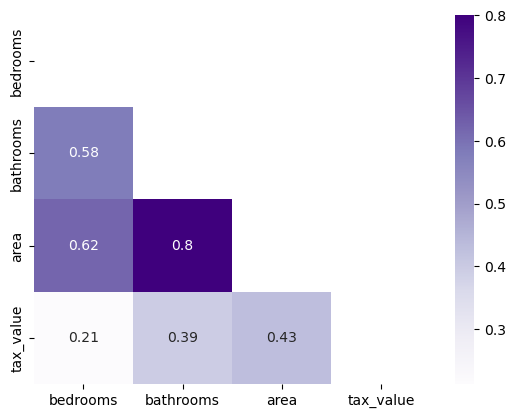

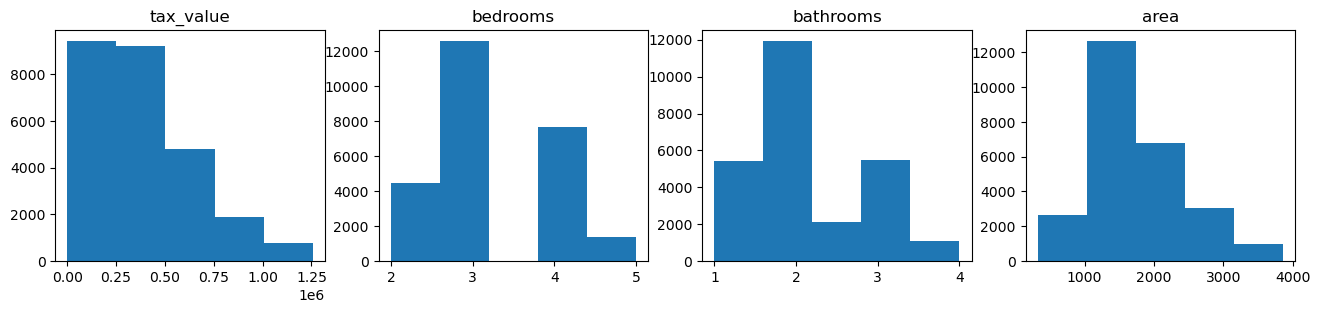

In [5]:
# get the distibution and correlation visuals of the features
m.get_distribution_and_corr(train)

- features have not normal distribution
- correlation pretty low for the features and the target


## Q1 What is the relationship bedrooms and tax_value?

#### H$_ø$: There is no realationship between bedrooms and tax_value
#### H$_a$: There is a relationshop between bedrroms and tax_value

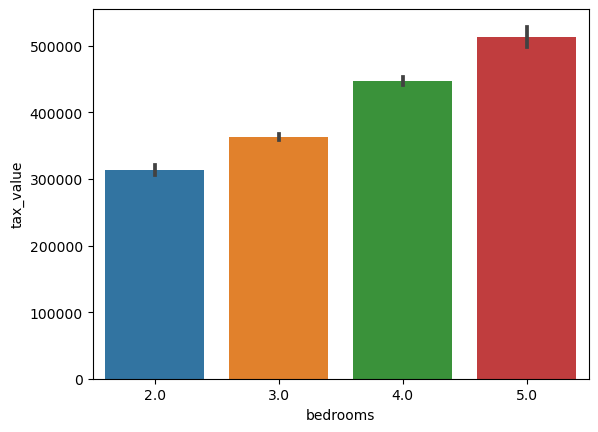

In [6]:
# returns a barplot for the target and the feature
m.get_visual(train, 'bedrooms', 'tax_value', sns.barplot)

- appears to have correlation
- as bedroom amount increases so does the tax_value
- Lets do a stats test to be sure

### Stats test

In [7]:
# Get stats test for x and y 
m.stats_test('bedrooms', 'tax_value', train)

We can reject our null hypothesis with a p-value: 1.665954194223961e-263
The correlation is 0.21232231429211643


- since our features do not have normal distribution a spearmansR test was preformed
- The P value is lower then the alpha (0.05) the null hypthesis was rejected
- not a very strong correlation 

### Q2 Is there a realationship between bathrooms and tax_value

#### H$_ø$: There is no realationship between bathrooms and tax_value
#### H$_a$: There is a relationshop between bathrooms and tax_value

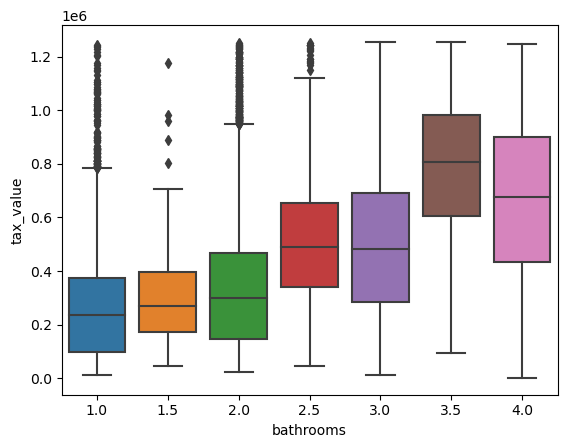

In [8]:
m.get_visual(train, 'bathrooms', 'tax_value', sns.boxplot)

- boxplot shows some correlation but with a lot of outliers in 1 - 2.5 bathrooms
- lets do another stats test to confirm

### Stats test

In [9]:
# Get stats test for x and y 
m.stats_test('bathrooms', 'tax_value', train)

We can reject our null hypothesis with a p-value: 0.0
The correlation is 0.394542210251


- The P value is lower then the alpha (0.05) the null hypthesis was rejected
- Not a strong correlations but better than bedrooms

## Q3 relationship between area and bathrooms?

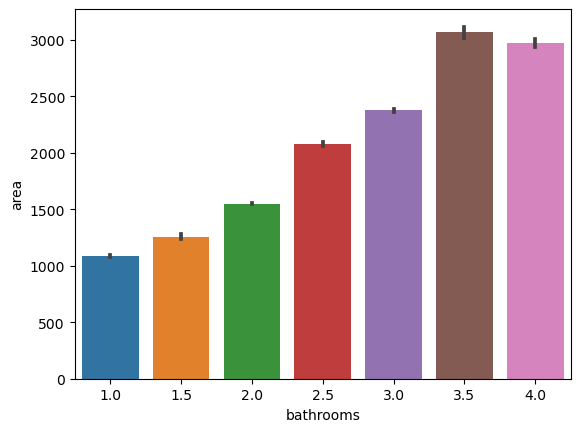

In [10]:
m.get_visual(train, 'bathrooms', 'area', sns.barplot)

- Appears to have great correlation 
- still want to do stats test to make sure

### Stats test

In [11]:
# Get stats test for x and y 
m.stats_test('bathrooms', 'area', train)

We can reject our null hypothesis with a p-value: 0.0
The correlation is 0.8009813508460654


- Null hypothesis is rejected 
- correlation is really high 

## Q4 What is the realtion between area and tax value?

#### H$_ø$: There is no realationship between area and tax_value
#### H$_a$: There is a relationshop between area and tax_value

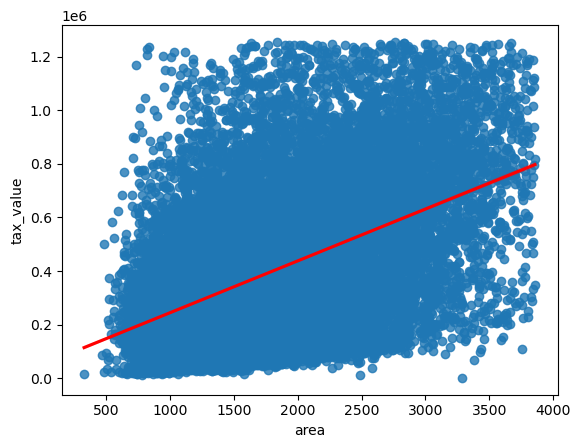

In [12]:
m.get_regplot(train, 'area', 'tax_value')

- Best fit line of regression pretty bad
- Let's check the correlation and P value


In [13]:
# Get stats test for x and y 
m.stats_test('area', 'tax_value', train)

We can reject our null hypothesis with a p-value: 0.0
The correlation is 0.43064331653991156


- we can rejected the null hypothesis
- correlation is stronger then expected although pretty low still

# Exploration Summary

- Correlation for the features to the target pretty low
- The best being area but still pretty low at 43%
- Bathrooms and area had an unexpectedly high correlation at 80%
- Going to move on to modeling with the features:
    - Bedrooms
    - Bathrooms
    - Area

# Let's Scale the data!

In [14]:
# Get the data scaled for train, val, test but only fit on train
train_scale, val_scale, test_scale = wr.scale_data(train, val, test)

In [15]:
train_scale

,bedrooms,bathrooms,area,tax_value,fips,sale_date
31478,4.0,2.0,0.311155,147333.0,6059.0,2017-06-15
30505,3.0,2.0,0.236127,475000.0,6037.0,2017-06-09
44417,2.0,1.0,0.111552,37645.0,6037.0,2017-08-11
36508,4.0,2.0,0.360419,75122.0,6037.0,2017-07-04
17712,3.0,2.0,0.257644,658896.0,6037.0,2017-04-14
...,...,...,...,...,...,...
49333,3.0,1.0,0.201586,300000.0,6037.0,2017-09-01
25047,3.0,2.0,0.237542,380000.0,6111.0,2017-05-17
23483,2.0,2.0,0.369479,331462.0,6059.0,2017-05-10
44163,4.0,2.5,0.468007,428006.0,6059.0,2017-08-10


- Only feature to be scaled was area, since bedrooms and bathrooms are more discrete than continuous 


# Modeling


In [16]:
#Let's get the x and y for or train, val, test
x_train, y_train, x_val, y_val, x_test, y_test = m.get_target_and_features(train_scale, val_scale, test_scale)

In [17]:
x_train

,bedrooms,bathrooms,area
31478,4.0,2.0,0.311155
30505,3.0,2.0,0.236127
44417,2.0,1.0,0.111552
36508,4.0,2.0,0.360419
17712,3.0,2.0,0.257644
...,...,...,...
49333,3.0,1.0,0.201586
25047,3.0,2.0,0.237542
23483,2.0,2.0,0.369479
44163,4.0,2.5,0.468007


## Let's get the baseling predictions

In [18]:
# Get baseline predictions using the mean
m.get_baseline(y_train, y_val)
y_train

RMSE using Mean
        Train/In-Sample: 261678.34 
        Validate/Out-of-Sample: 257877.5


,tax_value,tax_value_baseline
31478,147333.0,387043.487593
30505,475000.0,387043.487593
44417,37645.0,387043.487593
36508,75122.0,387043.487593
17712,658896.0,387043.487593
...,...,...
49333,300000.0,387043.487593
25047,380000.0,387043.487593
23483,331462.0,387043.487593
44163,428006.0,387043.487593


## Linear Regression

In [19]:
# Get the linear regression model and print the RMSE for train and validate
m.lr(x_train, y_train, x_val, y_val)

RMSE for OLS using LinearRegression
        Training/In-Sample:  227888.18646744313 
        Validation/Out-of-Sample: 227808.44877616025


# LassoLars

In [20]:
# Get the lasso lars model and print the RMSE for train and validate
m.lassolars(x_train, y_train, x_val, y_val)

RMSE for Lasso + Lars
        _____________________
        Training/In-Sample: 227888.18650013825, 
        Validation/Out-of-Sample:  227808.3677273643
        Difference:  -79.81877277395688


# Tweedie Regressor

In [21]:
# Get the tweedie regressor model and print the RMSE for train and validate
m.tweedie(x_train, y_train, x_val, y_val)

RMSE for GLM using Tweedie, power=1 & alpha=0
        _____________________
        Training/In-Sample: 228178.97805479032, 
        Validation/Out-of-Sample:  228669.6608239885
        Difference:  490.68276919817436


# Polynomial

In [22]:
# Get the Polynomial model and print the RMSE for train and validate
m.get_poly(x_train, y_train, x_val, y_val, x_test, y_test)

RMSE for Polynomial Model, degrees=2
        _____________________________________________
        Training/In-Sample:  227591.94913213322 
        Validation/Out-of-Sample:  227857.6013631253


# Comparing Models

In [23]:
m.compare_models(x_train, y_train, x_val, y_val, x_test, y_test)

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,261678.338683,257877.499525,0.000000
1,OLS Regressor,227888.186467,227808.448776,0.219555
2,Lars lasso,227888.186500,227808.367727,0.219556
3,Tweedie Regressor,228178.978055,228669.660824,0.213630
4,quadratic,227591.949132,227857.601363,0.219209


- Looking at all the models the LASSO LARS has the better R2 score and RMSE
- Going to test on the lars lasso

## Lasso Lars on test data

In [24]:
m.test_model(x_train, y_train, x_val, y_val, x_test, y_test)

RMSE for OLS using LinearRegression
    Test_rmse:  232019.98015367152 
    R2: 0.2277632211116306


# Model Summary

- All models preformed higher then the baseline
- Overall, it seems that the OLS Regressor and Lasso Lars models are the best performers based on RMSE values, while all four models seem to be performing similarly based on R2 values.
- I decided to evaluate the Lasso Lars model, as it displayed a slightly superior performance compared to OLS Rgressor model.

# Conclusions

## Exploration
- The correlation between the features and the target variable is relatively low, with the highest correlation being 43% for the feature 'area'. However, it is worth noting that the correlation between 'bathrooms' and 'area' is surprisingly high at 80%. 

## Modeling
- Models preformed very simularly 
- Lars lasso and OLS regressor were the best preformers based on the RMSE and R2 score

# Reccomendations
- Although models preformed better than the baseline ,using the three features alone 
    for modeling proved to be low preforming. I reccomend to use more features for developing higher preforming models 


# Next Steps
- explore more features for modeling
- develope different models specificly for each fips code 
